In [1]:
import matplotlib.pyplot as plt
import os
import fsspec 

from oorcas import HydrophoneDay
from datetime import timedelta, datetime
from pathlib import Path 
from obspy import Trace, Stream, UTCDateTime

from IPython.display import Audio

In [2]:
FILL_VALUE=None
METHOD=1

In [3]:
# are there whales?
hyd = HydrophoneDay("CE04OSBP-LJ01C-11-HYDBBA105", "2024/02/11")

https://rawdata.oceanobservatories.org/files/CE04OSBP/LJ01C/11-HYDBBA105/2024/02/11/


In [4]:
hyd.file_str

'CE04OSBP-LJ01C-11-HYDBBA105_2024_02_11'

In [ ]:
%%time
hyd.read_and_repair_gaps(fill_value=FILL_VALUE, method=METHOD, wav_data_subtype="PCM_32")

total traces before concatenation: 601
There are 19200000 samples in this stream, Simply concatenating
total traces after concatenation: 1
total traces before concatenation: 601
There are 19200000 samples in this stream, Simply concatenating
total traces after concatenation: 1
total traces before concatenation: 601
There are 19200000 samples in this stream, Simply concatenating
total traces after concatenation: 1
total traces before concatenation: 606
There are 19200000 samples in this stream, Simply concatenating
total traces after concatenation: 1
total traces before concatenation: 601
There are 19200000 samples in this stream, Simply concatenating
total traces before concatenation: 602
There are 19200000 samples in this stream, Simply concatenating
total traces after concatenation: 1
total traces after concatenation: 1
total traces before concatenation: 601
There are 19200000 samples in this stream, Simply concatenating
total traces after concatenation: 1
total traces before concate

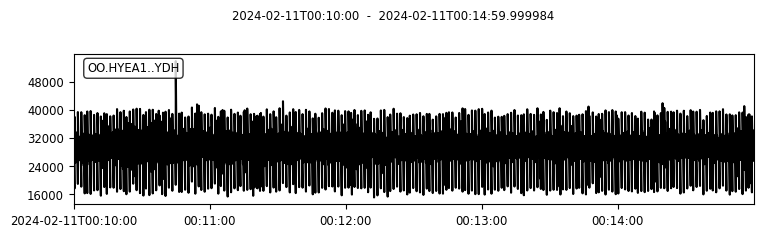

In [6]:
# hyd_org = hydsdfs8_ 3
for stream in hyd.clean_list:
    if hasattr(stream, 'traces'):  
        for trace in stream.traces:
            trace.plot()
            break
        break

In [7]:

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

def compute_simple_spectrogram(data, fs, nperseg=256):
    f, t, Sxx = signal.spectrogram(data, fs, nperseg=nperseg)
    
    Sxx_subsampled = Sxx[::10, ::10]
    f_subsampled = f[::10]
    t_subsampled = t[::10]

    plt.figure(figsize=(4, 3))
    plt.pcolormesh(t_subsampled, f_subsampled, 10 * np.log10(Sxx_subsampled), shading='gouraud')
    plt.title('Subsampled Spectrogram')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    plt.colorbar(label='Intensity [dB]')
    plt.show()

    return f, t, Sxx


In [8]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import xarray as xr

def compute_psd_welch_and_plot(data, fs, win="hann", L=4096, overlap=0.5, avg_method="median", 
                                interpolate=None, scale="log"):
    nfft = L if interpolate is None else int(fs / interpolate) if fs / L > interpolate else L

    f, Pxx = signal.welch(
        x=data,
        fs=fs,
        window=win,
        nperseg=L,
        noverlap=int(L * overlap),
        nfft=nfft,
        average=avg_method,
    )

    if scale == "log":
        Pxx = 10 * np.log10(Pxx)
    
    psd_xr = xr.DataArray(
        np.array(Pxx),
        dims=["frequency"],
        coords={"frequency": np.array(f)},
        attrs=dict(
            nperseg=L,
            units="dB re µPa^2 / Hz",
        ),
        name="psd",
    )

    f_subsampled = f[::10]
    Pxx_subsampled = Pxx[::10]

    plt.figure(figsize=(4, 3))
    plt.plot(f_subsampled, Pxx_subsampled)
    plt.title('Subsampled Power Spectral Density')
    plt.ylabel('PSD [dB re 1µPa^2 / Hz]')
    plt.xlabel('Frequency [Hz]')
    plt.xscale('log') 
    plt.show()

    return psd_xr


In [9]:
def compute_spectrogram_and_plot_heatmap(data, fs, win="hann", L=4096, overlap=0.5, scale="log"):

    f, t, Sxx = signal.spectrogram(
        x=data,
        fs=fs,
        window=win,
        nperseg=L,
        noverlap=int(L * overlap),
        scaling='density'
    )

    if scale == "log":
        Sxx = 10 * np.log10(Sxx)
    
    plt.figure(figsize=(4, 3))
    plt.imshow(Sxx, aspect='auto', origin='lower', extent=[t.min(), t.max(), f.min(), f.max()],
               cmap='inferno', interpolation='nearest')
    plt.colorbar(label='PSD [dB re 1µPa^2 / Hz]')
    plt.title('Spectrogram Heatmap')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    plt.ylim(f.min(), f.max())
    plt.xlim(t.min(), t.max())
    plt.grid(False)
    plt.show()


In [10]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import soundfile as sf

def plot_complex_spectrogram(f, t, Zxx):

    plt.figure(figsize=(4, 3))
    plt.imshow(20 * np.log10(np.abs(Zxx)), aspect='auto', origin='lower', 
               extent=[t.min(), t.max(), f.min(), f.max()],
               cmap='inferno', interpolation='nearest')
    plt.colorbar(label='Magnitude [dB]')
    plt.title('Magnitude Spectrogram')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    plt.ylim(f.min(), f.max())
    plt.xlim(t.min(), t.max())
    plt.grid(False)
    plt.show()

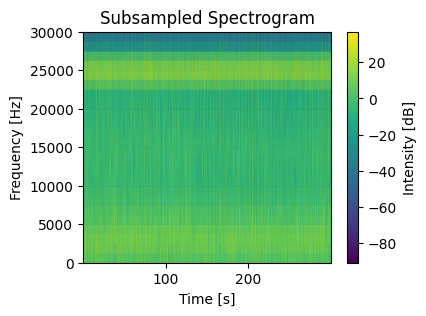

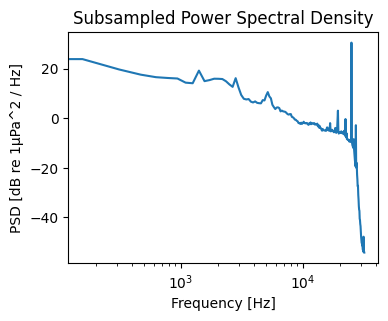

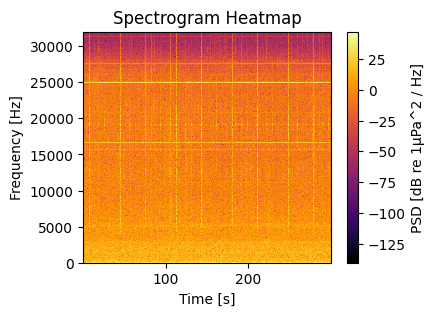

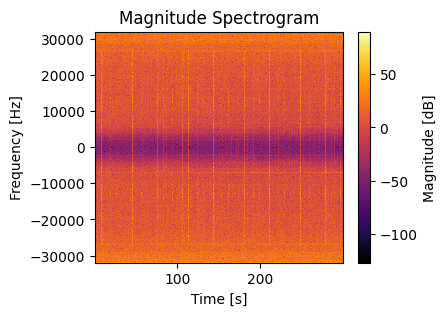

In [11]:
win = "hann"
L = 4096
overlap = 0.5

for stream in hyd.clean_list:
    if hasattr(stream, 'traces'):  
        for trace in stream.traces:
            fs = 64000
            f, t, Sxx = compute_simple_spectrogram(trace.data, fs)
            psd_result = compute_psd_welch_and_plot(trace, fs)
            compute_spectrogram_and_plot_heatmap(trace.data, fs)
            
            
            f, t, Zxx = signal.stft(
                x=trace.data,
                fs=fs,
                window=win,
                nperseg=L,
                noverlap=int(L * overlap),
                boundary=None,
                return_onesided=False
            )
                
            plot_complex_spectrogram(f, t, Zxx)
            
            _, reconstructed_signal = signal.istft(Zxx, fs=fs, window=win, nperseg=L, noverlap=int(L * overlap))
            sf.write('reconstructed_signal.wav', reconstructed_signal, fs)
            
            break
        break

# Old tracing stuff

In [ ]:
import numpy as np
from obspy.core.trace import Trace

target_dtype = np.int16

for stream in hyd.clean_list:
    if hasattr(stream, 'traces'):  
        for trace in stream.traces:
            if not isinstance(trace, Trace):
                print('yikes')
            else:
                if trace.data.dtype != target_dtype:
                    print(f"Converting dtype from {trace.data.dtype} to {target_dtype}")
                    trace.data = trace.data.astype(target_dtype)
    else:
        print('Not a stream:', stream)

Converting dtype from int32 to <class 'numpy.int16'>
Converting dtype from int32 to <class 'numpy.int16'>
Converting dtype from int32 to <class 'numpy.int16'>
Converting dtype from int32 to <class 'numpy.int16'>
Converting dtype from int32 to <class 'numpy.int16'>
Converting dtype from int32 to <class 'numpy.int16'>
Converting dtype from int32 to <class 'numpy.int16'>
Converting dtype from int32 to <class 'numpy.int16'>
Converting dtype from int32 to <class 'numpy.int16'>
Converting dtype from int32 to <class 'numpy.int16'>


In [ ]:
for i, item in enumerate(hyd.clean_list):
    if hasattr(item, 'traces'):
        continue
    else:
        print(f"Item {i}: {item}")
        print(f"  Item {i} is not a Stream, it is a {type(item)}.")

In [ ]:
print(f"Type of hyd.clean_list: {type(hyd.clean_list)}")
print(f"Length of hyd.clean_list: {len(hyd.clean_list)}")
types_list = [str(type(item)) for item in hyd.clean_list]

unique_types, counts = np.unique(types_list, return_counts=True)
for ut, count in zip(unique_types, counts):
    print(f"{ut}: {count}")

Type of hyd.clean_list: <class 'list'>
Length of hyd.clean_list: 10
<class 'obspy.core.stream.Stream'>: 10


In [ ]:
for stream in hyd.clean_list:
    for trace in stream.traces:
        print(trace.data.dtype)
        dtype = {}
        dtype.setdefault(trace.id, trace.data.dtype)
        print(dtype[trace.id])

int16
int16
int16
int16
int16
int16
int16
int16
int16
int16
int16
int16
int16
int16
int16
int16
int16
int16
int16
int16


In [ ]:
target_dtype = np.int32
dtype_dict = {}

for stream in hyd.clean_list:
    for trace in stream.traces:
        print(f"Trace ID: {trace.id}, Data Type: {trace.data.dtype}")
        
        if trace.id not in dtype_dict:
            dtype_dict[trace.id] = trace.data.dtype
        elif dtype_dict[trace.id] != trace.data.dtype:
            print(f"Mismatch found for Trace ID: {trace.id}")

        if trace.data.dtype != target_dtype:
            trace.data = trace.data.astype(target_dtype)
            print(f"Converted Trace ID: {trace.id} to {target_dtype}")

# forcing it to work by changing ids
for stream_index, stream in enumerate(hyd.clean_list):
    for trace_index, trace in enumerate(stream.traces):
        original_id = trace.id
        trace.id = f"{original_id}_stream{stream_index}_trace{trace_index}"

try:
    hyd.create_single_stream(fill_value=None, method=1)
except Exception as e:
    print(f"Error: {e}")


Trace ID: OO.HYEA1..YDH, Data Type: int16
Converted Trace ID: OO.HYEA1..YDH to <class 'numpy.int32'>
Trace ID: OO.HYEA1..YDH, Data Type: int16
Converted Trace ID: OO.HYEA1..YDH to <class 'numpy.int32'>
Trace ID: OO.HYEA1..YDH, Data Type: int16
Converted Trace ID: OO.HYEA1..YDH to <class 'numpy.int32'>
Trace ID: OO.HYEA1..YDH, Data Type: int16
Converted Trace ID: OO.HYEA1..YDH to <class 'numpy.int32'>
Trace ID: OO.HYEA1..YDH, Data Type: int16
Converted Trace ID: OO.HYEA1..YDH to <class 'numpy.int32'>
Trace ID: OO.HYEA1..YDH, Data Type: int16
Converted Trace ID: OO.HYEA1..YDH to <class 'numpy.int32'>
Trace ID: OO.HYEA1..YDH, Data Type: int16
Converted Trace ID: OO.HYEA1..YDH to <class 'numpy.int32'>
Trace ID: OO.HYEA1..YDH, Data Type: int16
Converted Trace ID: OO.HYEA1..YDH to <class 'numpy.int32'>
Trace ID: OO.HYEA1..YDH, Data Type: int16
Converted Trace ID: OO.HYEA1..YDH to <class 'numpy.int32'>
Trace ID: OO.HYEA1..YDH, Data Type: int16
Converted Trace ID: OO.HYEA1..YDH to <class 'nump

2024-10-31 12:34:42.955 | INFO     | oorcas.hydrophone_day:create_single_stream:121 - Merging to a single stream for the day
2024-10-31 12:34:42.958 | WARNING  | oorcas.hydrophone_day:_clean_day_edges:231 - End of day: 2024-02-11T00:09:59.999984Z - appears to be incomplete due to diversion - setting manually
2024-10-31 12:34:42.958 | INFO     | oorcas.hydrophone_day:_clean_day_edges:237 - Adding dummy trace to day end


Error: Can't merge traces with same ids but differing data types!


c:\Users\catra\anaconda3\envs\WHALE_PROJ\Lib\site-packages\obspy\core\stream.py:3042: UserWarning: Incompatible traces (sampling_rate, dtype, ...) with same id detected. Doing nothing.
  warnings.warn(msg)


In [ ]:
# %%time
# day_fig = hyd.plot_spectrogram(avg_time=1, L=2048)

In [ ]:
for stream_index, stream in enumerate(hyd.clean_list):
    print(f"Stream {stream_index}:")
    for trace_index, trace in enumerate(stream.traces):
        print(f"  Trace {trace_index}:")
        print(f"    ID: {trace.id}")
        print(f"    Data Type: {trace.data.dtype}")
        print(f"    Data Length: {len(trace.data)}")
        print(f"    Sampling Rate: {trace.stats.sampling_rate}")
        print(f"    Start Time: {trace.stats.starttime}")
        print(f"    End Time: {trace.stats.endtime}")
        print(f"    First 5 Data Points: {trace.data[:5]}")
        print(f"    Last 5 Data Points: {trace.data[-5:]}")
        break
    break

Stream 0:
  Trace 0:
    ID: OO.HYEA1..YDH_stream0_trace0
    Data Type: int32
    Data Length: 19200000
    Sampling Rate: 64000.0
    Start Time: 2024-02-11T00:05:00.000000Z
    End Time: 2024-02-11T00:09:59.999984Z
    First 5 Data Points: [30042 29360 30091 29304 30117]
    Last 5 Data Points: [29197 28456 28238 29082 30120]


In [ ]:
# should be 5 (len in minutes)
len(hyd.clean_list[0][0].data) /  hyd.clean_list[0][0].stats.sampling_rate / 60.0

5.0

In [ ]:
len(hyd.clean_list[0][0].data) / (hyd.clean_list[0][0].stats.sampling_rate * 5)

60.0

In [ ]:
X = 0.5

data = hyd.clean_list[0][0].data
sampling_rate = hyd.clean_list[0][0].stats.sampling_rate

samples_per_Xs = sampling_rate * X
subsampled_data = data[::int(samples_per_Xs)]
num_subsampled_points = len(subsampled_data)  
new_sampling_rate = sampling_rate * X
times = np.arange(num_subsampled_points) / new_sampling_rate

In [100]:
# window_size = 5
# window_size = int(window_size / X)
# overlap = 2
# overlap = int(overlap / X)
# hop_size = window_size - overlap

# num_windows = (num_subsampled_points - overlap) // hop_size

# Sxx = np.zeros((window_size // 2 + 1, num_windows))

# window = np.hamming(window_size)

# for i in range(num_windows):
#     start = i * hop_size
#     segment = subsampled_data[start:start + window_size] * window
#     fft_result = np.fft.rfft(segment)
#     Sxx[:, i] = np.abs(fft_result) ** 2

# frequencies = np.fft.rfftfreq(window_size, d=1/new_sampling_rate)
# times = np.arange(num_windows) * (hop_size / new_sampling_rate)

# plt.figure(figsize=(10, 6))
# plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud', cmap='plasma')
# plt.colorbar(label='Intensity [dB]')
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [s]')
# # plt.title('Spectrogram of Subsampled Data')
# plt.ylim(0, np.max(frequencies))
# plt.show()

In [ ]:
hyd.filter("bandpass")

# Autoencoder

In [12]:
# whatver PCA time lol

max_streams = 50

data_matrix = []
for stream_index, stream in (enumerate(hyd.clean_list[:max_streams])):
    for trace_index, trace in enumerate(stream.traces):
        data_matrix.append(trace.data[::1000])       # TODO: remove ::1000 when needed

data_matrix = np.array(data_matrix)

In [13]:
data_matrix.shape

(50, 19200)

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import numpy as np

data_matrix = np.array(data_matrix, dtype=np.float32)
data_matrix = (data_matrix - data_matrix.mean()) / data_matrix.std()

data_tensor = torch.tensor(data_matrix)

train_data, temp_data = train_test_split(data_tensor, test_size=0.4, random_state=42)  # 60% train
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)  # 20% val, 20% test

train_dataset = TensorDataset(train_data, train_data)
val_dataset = TensorDataset(val_data, val_data)
test_dataset = TensorDataset(test_data, test_data)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

class AudioAutoencoder(nn.Module):
    def __init__(self):
        super(AudioAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(data_matrix.shape[1], 4800),
            nn.ReLU(),
            nn.Linear(4800, 2400),
            nn.ReLU(),
            nn.Linear(2400, 1200)
        )
        self.decoder = nn.Sequential(
            nn.Linear(1200, 2400),
            nn.ReLU(),
            nn.Linear(2400, 4800),
            nn.ReLU(),
            nn.Linear(4800, data_matrix.shape[1]),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = AudioAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 5
for epoch in range(epochs):
    model.train()
    for inputs, _ in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, _ in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item() * inputs.size(0)
    
    val_loss /= len(val_loader.dataset)
    print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}")

model.eval()
test_loss = 0
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        test_loss += loss.item() * inputs.size(0)

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")

print("Training complete.")


Epoch 1/5:   0%|          | 0/15 [00:00<?, ?it/s]

: 

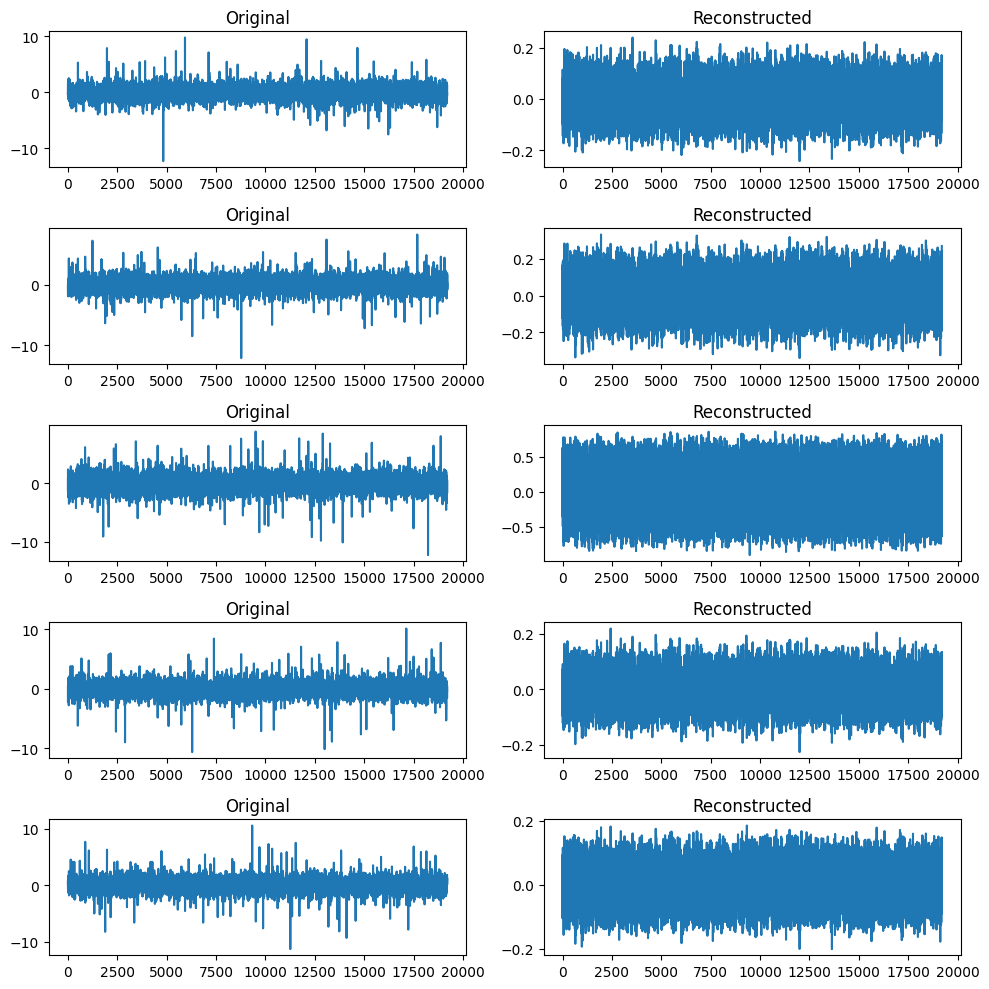

In [27]:
def visualize_reconstructions(model, data_tensor, n_samples=5):
    model.eval()
    with torch.no_grad():
        inputs = data_tensor[:n_samples]
        reconstructed = model(inputs)

    fig, axes = plt.subplots(n_samples, 2, figsize=(10, n_samples * 2))
    for i in range(n_samples):
        axes[i, 0].plot(inputs[i].numpy())
        axes[i, 0].set_title("Original")
        
        axes[i, 1].plot(reconstructed[i].numpy())
        axes[i, 1].set_title("Reconstructed")
    
    plt.tight_layout()
    plt.show()

visualize_reconstructions(model, data_tensor)


# PCA

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
pca_result = pca.fit_transform(data_matrix)

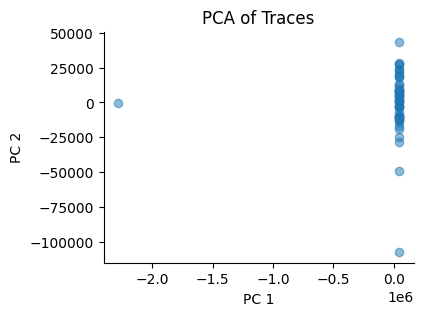

In [14]:
plt.figure(figsize=(4, 3))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.title('PCA of Traces')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.gca().spines['top'].set_visible(False); plt.gca().spines['right'].set_visible(False)
plt.show()

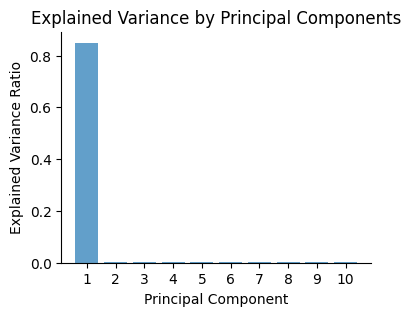

In [18]:
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(4, 3))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.xticks(range(1, len(explained_variance) + 1))
plt.gca().spines['top'].set_visible(False); plt.gca().spines['right'].set_visible(False)
plt.show()

In [17]:
explained_variance

array([0.84971915, 0.00397268, 0.00391115, 0.00370419, 0.00364453,
       0.00355816, 0.00346549, 0.00342081, 0.00337352, 0.00330634])

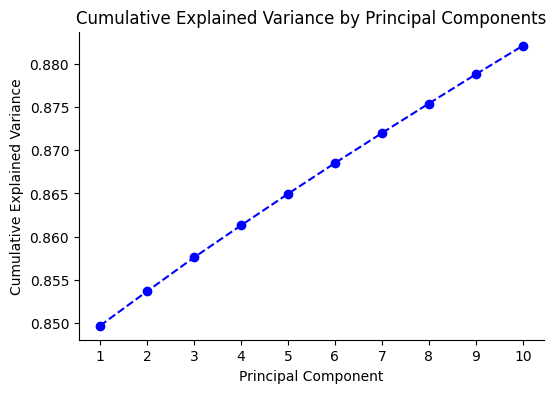

In [16]:
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(6, 4))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xticks(range(1, len(cumulative_variance) + 1))
# plt.grid()
plt.gca().spines['top'].set_visible(False); plt.gca().spines['right'].set_visible(False)  # Remove top and right spines
plt.show()

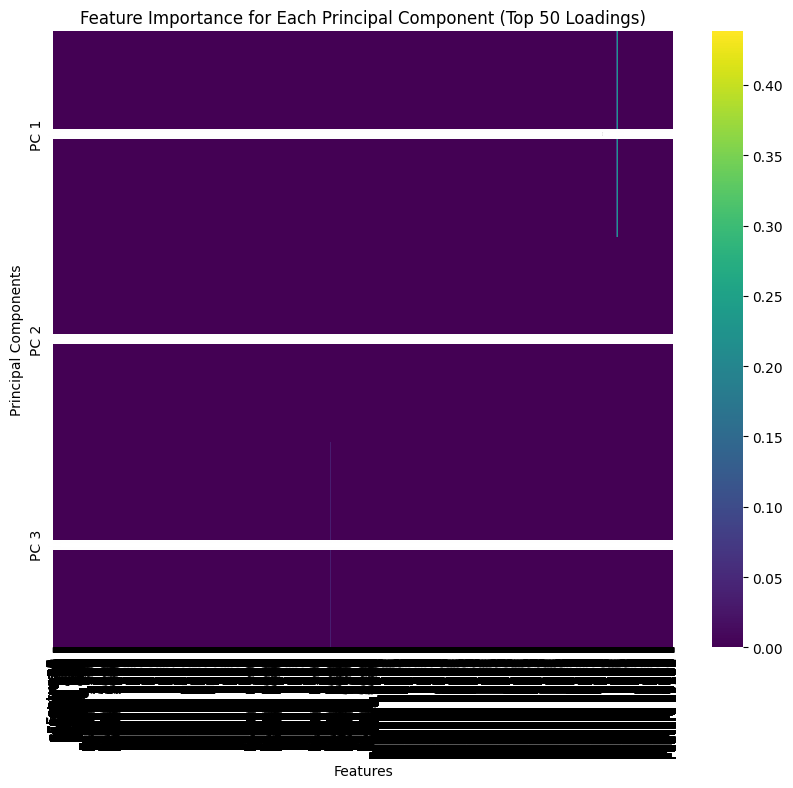

<Figure size 640x480 with 0 Axes>

In [29]:
# import seaborn as sns

# loadings = np.abs(pca.components_)

# # just get the top 50
# flat_loadings = loadings.flatten()
# top_50_indices = np.argsort(flat_loadings)[-50:]
# mask = np.zeros(flat_loadings.shape, dtype=bool)
# mask[top_50_indices] = True
# masked_loadings = flat_loadings * mask
# masked_loadings = masked_loadings.reshape(loadings.shape)

# plt.figure(figsize=(10, 8))
# sns.heatmap(masked_loadings, cmap='viridis', annot=True, fmt=".2f", cbar=True,
#             xticklabels=[f"Feature {i+1}" for i in range(data_matrix.shape[1])],
#             yticklabels=[f"PC {i+1}" for i in range(loadings.shape[0])])
# plt.title("Feature Importance for Each Principal Component (Top 50 Loadings)")
# plt.xlabel("Features")
# plt.ylabel("Principal Components")
# plt.show()
# plt.savefig('pc_feat_importance_top50.png')

# Clustering

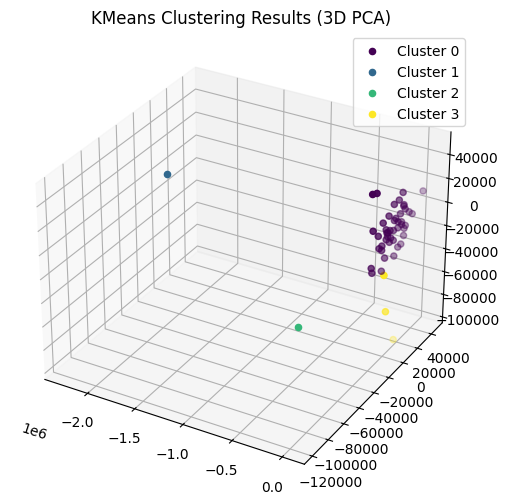

In [38]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# data_matrix = np.array(data_matrix, dtype=np.float32)

n_components = 3 
pca = PCA(n_components=n_components)
data_pca = pca.fit_transform(data_matrix)

n_clusters = 4  
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(data_pca)

labels = kmeans.labels_


colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

if n_components == 2:
    plt.figure(figsize=(12, 6))
    for i in range(n_clusters):
        plt.scatter(data_pca[labels == i, 0], data_pca[labels == i, 1], 
                    color=colors[i], label=f'Cluster {i}')
    plt.title('KMeans Clustering Results (2D PCA)')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(label='Cluster Label')
    plt.legend()
    plt.show()
elif n_components == 3:
    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(111, projection='3d')
    for i in range(n_clusters):
        ax.scatter(data_pca[labels == i, 0], data_pca[labels == i, 1], 
                   data_pca[labels == i, 2], color=colors[i], label=f'Cluster {i}')
    ax.set_title('KMeans Clustering Results (3D PCA)')

    ax.legend()
    plt.show()


In [30]:
new_sample = np.array(data_matrix[0]).reshape(1, -1)

new_sample_pca = pca.transform(new_sample)

predicted_cluster = kmeans.predict(new_sample_pca)

print(f'The new sample belongs to cluster: {predicted_cluster[0]}')

The new sample belongs to cluster: 0


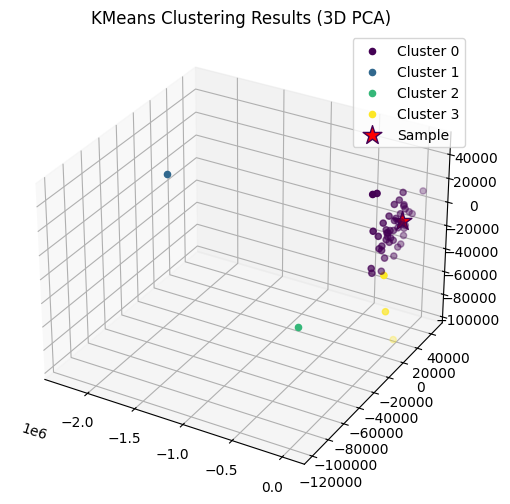

In [ ]:
if n_components == 2:
    plt.figure(figsize=(7, 6))
    for i in range(n_clusters):
        plt.scatter(data_pca[labels == i, 0], data_pca[labels == i, 1], 
                    color=colors[i], label=f'Cluster {i}')
    
    plt.scatter(new_sample_pca[0, 0], new_sample_pca[0, 1], 
                color=colors[predicted_cluster], marker='*', s=200, label='New Sample')
    plt.title('KMeans Clustering predicted_cluster (2D PCA)')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(label='Cluster Label')
    plt.legend() 
    plt.show()
elif n_components == 3:
    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(111, projection='3d')
       
    for i in range(n_clusters):
        ax.scatter(data_pca[labels == i, 0], data_pca[labels == i, 1], 
                   data_pca[labels == i, 2], color=colors[i], label=f'Cluster {i}')
     
    ax.scatter(new_sample_pca[0, 0], new_sample_pca[0, 1], new_sample_pca[0, 2], 
            color='red', marker='*', s=200, label='Sample', edgecolor=colors[predicted_cluster])
    
    ax.set_title('KMeans Clustering Results (3D PCA)')
    # ax.set_xlabel('PCA Component 1')
    # ax.set_ylabel('PCA Component 2')
    # ax.set_zlabel('PCA Component 3')
    ax.legend() 
    plt.show()

In [63]:
data_matrix.shape

(50, 19200)

In [64]:
import pickle


with open('pca_data.pkl', 'wb') as f:
    pickle.dump({
        'data_matrix': data_matrix,
        'pca': pca,
        'data_pca': data_pca
    }, f)

print("Data saved successfully as pca_data.pkl")

Data saved successfully as pca_data.pkl


In [ ]:

with open('pca_data.pkl', 'rb') as f:
    data = pickle.load(f)

data_matrix = data['data_matrix']
pca = data['pca']
data_pca = data['data_pca']

print("Data loaded successfully.")
print("Shape of data_matrix:", data_matrix.shape)
print("PCA Components shape:", data_pca.shape)

Data loaded successfully.
Shape of data_matrix: (50, 19200)
PCA Components shape: (50, 3)


In [ ]:
# save data_pca, pca, data_matrix

In [ ]:
# TODO: 
# - whale detection
# - clustering automatic
